In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

In [207]:
#df = pd.read_csv('train.csv', index_col=[0])

# Feature Engineering

In [7]:
DATA_DIR = 'C:/Users/gybj0/Desktop/data'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import os

train = pd.read_csv(os.path.join(DATA_DIR, 'optiver_volatility', 'train.csv'))
stock_ids = set(train['stock_id'])

def load_stock_data(stock_id: int, directory: str) -> pd.DataFrame:
    return pd.read_parquet(os.path.join(DATA_DIR, 'optiver_volatility', directory, f'stock_id={stock_id}'))

def load_book(stock_id: int, type:  str) -> pd.DataFrame:
    return load_stock_data(stock_id, f'book_{type}.parquet')

def load_trade(stock_id: int, type: str) -> pd.DataFrame:
    return load_stock_data(stock_id, f'trade_{type}.parquet')

def calc_wap1(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def realized_volatility(series: np.ndarray) -> pd.Series:
    return np.sqrt(np.sum(series**2))

def log_return(series: np.ndarray) -> pd.Series:
    return np.log(series).diff()

def log_return_df2(series: np.ndarray) -> pd.Series:
    return np.log(series).diff(2)

def rename(addon: str, columns) -> list:
    ret = []
    for col in columns:
        if col[0] in ['time_id','stock_id']:
            ret.append(col[0])
        else:
            ret.append('_'.join([addon]+list(col)))
    return ret

def make_book_feature(stock_id: int, type: str) -> pd.DataFrame:
    book = load_book(stock_id, type)

    book['wap1'] = calc_wap1(book)
    book['wap2'] = calc_wap2(book)
    book['log_return1'] = book.groupby(['time_id'])['wap1'].apply(log_return)
    book['log_return2'] = book.groupby(['time_id'])['wap2'].apply(log_return)
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].apply(log_return)
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].apply(log_return)
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].apply(log_return)
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].apply(log_return)

    book['wap_balance'] = abs(book['wap1'] - book['wap2'])
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1'] + book['bid_price1']) / 2)
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2']))

    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    #book = book.fillna(method = 'ffill').dropna()
    agg = book.groupby('time_id').agg(features).reset_index(drop=False)
    agg.columns = rename('book', agg.columns)
    agg['stock_id'] = stock_id   

    for time in [450, 300, 150]:
        d = book[book['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = rename(f'{time}', d.columns)
        agg = pd.merge(agg, d, on = 'time_id', how = 'left')
    return agg

def make_trade_feature(stock_id: int, type: str) -> pd.DataFrame:
    trade = load_trade(stock_id, type)
    trade['log_return'] = trade.groupby('time_id')['price'].apply(log_return)

    features = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':['count'],
        'size':[np.sum],
        'order_count':[np.mean],
    }

    #trade = trade.fillna(method = 'ffill').dropna()
    agg = trade.groupby('time_id').agg(features).reset_index()
    agg.columns = rename('trade', agg.columns)
    agg['stock_id'] = stock_id

    for time in [450, 300, 150]:
        d = trade[trade['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = rename(f'{time}', d.columns)
        agg = pd.merge(agg, d, on = 'time_id', how = 'left')
    return agg

def make_features(stock_ids: list[int], type: str) -> pd.DataFrame:
    from joblib import Parallel, delayed
    book = Parallel(n_jobs = -1)(delayed(make_book_feature)(i, type) for i in stock_ids)
    books = pd.concat(book)
    trade = Parallel(n_jobs = -1)(delayed(make_trade_feature)(i, type) for i in stock_ids)
    trades = pd.concat(trade)
    df = pd.merge(books, trades, on = ['time_id','stock_id'], suffixes = ['_book','_trade'])
    return df

In [209]:
df = make_features(stock_ids, 'train')

exception calling callback for <Future at 0x26cd0fff850 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "c:\Users\gybj0\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "c:\Users\gybj0\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "c:\Users\gybj0\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "c:\Users\gybj0\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\gybj0\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\U

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [ ]:
df.to_csv('feature_v2.csv')

In [4]:
df = pd.read_csv('feature_v2.csv', index_col = [0])

In [5]:
df.shape

(427233, 214)

In [8]:
test_df = make_features([0], 'test')

In [9]:
test_df.shape

(1, 214)

# Train, html split

In [10]:
time_ids = df.time_id.factorize()[1]
time_indexes = df.time_id.factorize()[0]
time_len = len(time_ids)
html_time = 0.1
train_time = time_ids[int((1 - html_time) * time_len)]

In [11]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

X_train = df.copy()
X_train['target'] = train.target

# Train NN

In [12]:
from sklearn.neighbors import NearestNeighbors

class Neighbors:
    def __init__(self, name: str, n_neighbor: int, pivot: pd.DataFrame):
        self.name = name
        self.n_neighbor = n_neighbor
        self.pivot = pivot
        nn = NearestNeighbors(n_neighbors=n_neighbor)
        nn.fit(pivot)
        self.nn_ind = nn.kneighbors(pivot, n_neighbors=n_neighbor, return_distance=False)
        self.time = X_train.time_id.factorize()[0]
        self.stock = X_train.stock_id.factorize()[0]       

    def make_nn_features(self, n: int, method=np.mean):
        assert(self.features is not None)

        self.agg = pd.DataFrame(
            method(self.features.iloc[:, 1:n], axis = 1),
            columns = [f'{self.name}_{str(n)}_{self.col}_{method.__name__}']
        )

class TimeNeighbors(Neighbors):
    def make_nn_time(self, pivot: pd.DataFrame, feature_col: str):
        pivot = pivot.pivot('time_id', 'stock_id', feature_col)
        pivot = pivot.fillna(pivot.mean())
        self.features = pd.DataFrame(pivot.values[self.nn_ind[self.time, 1:self.n_neighbor], self.stock[:, None]])
        self.col = feature_col

class StockNeighbors(Neighbors):        
    def make_nn_stock(self, pivot: pd.DataFrame, feature_col: str):
        pivot = pivot.pivot('time_id', 'stock_id', feature_col)
        pivot = pivot.fillna(pivot.mean())
        self.features = pd.DataFrame(pivot.T.values[self.nn_ind[self.stock, 1:self.n_neighbor], self.time[:, None]])
        self.col = feature_col


In [13]:
from sklearn.preprocessing import minmax_scale
time_neighbor = []
stock_neighbor = []
pv = X_train.copy()

pivot = pv.pivot('time_id','stock_id','book_log_return1_realized_volatility')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
time_neighbor.append(TimeNeighbors('time_vol', 40, pivot))

pivot = pv.pivot('time_id','stock_id','trade_size_sum')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
time_neighbor.append(TimeNeighbors('time_trade_size_sum', 40, pivot))

pivot = pv.pivot('time_id','stock_id','book_log_return1_mean')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
time_neighbor.append(TimeNeighbors('time_log_return1_mean', 40, pivot))

pivot = pv.pivot('time_id','stock_id','trade_order_count_mean')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
time_neighbor.append(TimeNeighbors('time_order_count_mean', 40, pivot))

pivot = pv.pivot('time_id','stock_id','book_log_return1_realized_volatility')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
stock_neighbor.append(StockNeighbors('stock_vol', 80, minmax_scale(pivot.T)))

pivot = pv.pivot('time_id','stock_id','book_log_return1_mean')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
stock_neighbor.append(StockNeighbors('stock_log_return1_mean', 80, minmax_scale(pivot.T)))


In [14]:
for i in df.columns:
    print(i)

time_id
book_seconds_in_bucket_count
book_wap1_sum
book_wap1_mean
book_wap1_std
book_wap2_sum
book_wap2_mean
book_wap2_std
book_log_return1_sum
book_log_return1_realized_volatility
book_log_return1_mean
book_log_return1_std
book_log_return2_sum
book_log_return2_realized_volatility
book_log_return2_mean
book_log_return2_std
book_log_return_ask1_sum
book_log_return_ask1_realized_volatility
book_log_return_ask1_mean
book_log_return_ask1_std
book_log_return_ask2_sum
book_log_return_ask2_realized_volatility
book_log_return_ask2_mean
book_log_return_ask2_std
book_log_return_bid1_sum
book_log_return_bid1_realized_volatility
book_log_return_bid1_mean
book_log_return_bid1_std
book_log_return_bid2_sum
book_log_return_bid2_realized_volatility
book_log_return_bid2_mean
book_log_return_bid2_std
book_wap_balance_sum
book_wap_balance_mean
book_wap_balance_std
book_price_spread_sum
book_price_spread_mean
book_price_spread_std
book_bid_spread_sum
book_bid_spread_mean
book_bid_spread_std
book_ask_spread

In [15]:
def cal_rank_correaltion(neighbors):
    rank = pd.DataFrame()
    for n in neighbors:
        print(n.name)
        rank[n.name] = n.nn_ind.flatten()

    sns.heatmap(rank.corr(), annot = True)

time_vol
time_trade_size_sum
time_log_return1_mean
time_order_count_mean


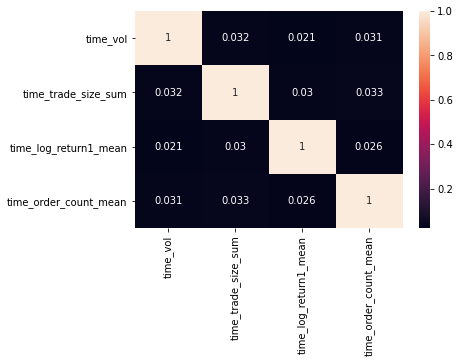

In [17]:
cal_rank_correaltion(time_neighbor)

stock_vol
stock_log_return1_mean


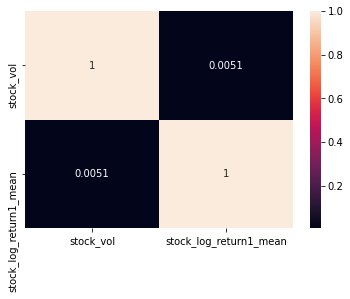

In [18]:
cal_rank_correaltion(stock_neighbor)

Integrate NN features

In [19]:
def make_nn_features(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()

    methods_stocks = {
        'book_log_return1_realized_volatility': [np.mean, np.min, np.max, np.std],
        'trade_order_count_mean': [np.mean],
        'book_log_return1_mean': [np.mean],
        'trade_size_sum': [np.mean],
        'book_seconds_in_bucket_count': [np.mean],
    }
    
    methods_time = {
        'book_log_return1_realized_volatility': [np.mean, np.min, np.max, np.std],
        'trade_order_count_mean': [np.mean],
        'book_log_return1_mean': [np.mean],
        'trade_size_sum': [np.mean],
        'book_seconds_in_bucket_count': [np.mean],
    }

    time_n = [2, 3, 5, 10, 20, 40]
    stock_n = [5, 10, 20, 40, 60, 80]
    cols = []

    for col in methods_time.keys():

        for nn in time_neighbor:
            nn.make_nn_time(df2, col)

        for method in methods_time[col]:
            for n in time_n:
                nn.make_nn_features(n, method)
                feat = nn.agg
                cols.append(feat)

    for col in methods_stocks.keys():

        for nn in stock_neighbor:
            nn.make_nn_stock(df2, col)

        for method in methods_stocks[col]:
            for n in stock_n:
                nn.make_nn_features(n, method)
                feat = nn.agg
                cols.append(feat)    
    
    ndf = pd.concat(cols, axis = 1)
    df2 = pd.concat([df2, ndf], axis = 1)
    return df2

In [20]:
df_nn = make_nn_features(X_train)

In [21]:
df_nn.shape

(427233, 311)

In [22]:
df_nn = df_nn.fillna(df_nn.mean())

In [23]:
import gc
gc.collect()

del df
del pv
del time_indexes
del train
del X_train

In [26]:
df_nn.to_csv('nn_features.csv')

# CV and test split

In [24]:
fold_bolder = [3830 - 383 * 5, 3830 - 383 * 4,3830 - 383 * 3,3830 - 383 * 2,3830 - 383 * 1,]
fold = []
df_nn = df_nn.sort_values(by = ['time_id', 'stock_id'])
df_nn = df_nn.reset_index()
for i in fold_bolder:
    idx_valid = time_ids[i: i + 383]
    ind_train = np.where(df_nn.time_id<idx_valid[0])[0]
    ind_valid = np.where((df_nn.time_id>=idx_valid[0])&(df_nn.time_id<idx_valid[-1]))[0]
    fold.append((ind_train, ind_valid))

In [25]:
fold

[(array([     0,      1,      2, ..., 215073, 215074, 215075], dtype=int64),
  array([215076, 215077, 215078, ..., 257700, 257701, 257702], dtype=int64)),
 (array([     0,      1,      2, ..., 257812, 257813, 257814], dtype=int64),
  array([257815, 257816, 257817, ..., 300853, 300854, 300855], dtype=int64)),
 (array([     0,      1,      2, ..., 300964, 300965, 300966], dtype=int64),
  array([300967, 300968, 300969, ..., 343675, 343676, 343677], dtype=int64)),
 (array([     0,      1,      2, ..., 343787, 343788, 343789], dtype=int64),
  array([343790, 343791, 343792, ..., 387055, 387056, 387057], dtype=int64)),
 (array([     0,      1,      2, ..., 387167, 387168, 387169], dtype=int64),
  array([387170, 387171, 387172, ..., 417637, 417638, 417639], dtype=int64))]

In [34]:
del ind_train
del ind_valid

# LGBM Training

In [27]:
df_train = df_nn[df_nn.index <= fold[-1][0][-1]]
df_test = df_nn[df_nn.index > fold[-1][0][-1]]

In [28]:
df_train

,index,time_id,book_seconds_in_bucket_count,book_wap1_sum,book_wap1_mean,book_wap1_std,book_wap2_sum,book_wap2_mean,book_wap2_std,book_log_return1_sum,...,stock_log_return1_mean_20_trade_size_sum_mean,stock_log_return1_mean_40_trade_size_sum_mean,stock_log_return1_mean_60_trade_size_sum_mean,stock_log_return1_mean_80_trade_size_sum_mean,stock_log_return1_mean_5_book_seconds_in_bucket_count_mean,stock_log_return1_mean_10_book_seconds_in_bucket_count_mean,stock_log_return1_mean_20_book_seconds_in_bucket_count_mean,stock_log_return1_mean_40_book_seconds_in_bucket_count_mean,stock_log_return1_mean_60_book_seconds_in_bucket_count_mean,stock_log_return1_mean_80_book_seconds_in_bucket_count_mean
0,0,5,301,302.123627,1.003733,0.000682,302.104149,1.003668,0.000771,0.002292,...,32508.052632,30122.487179,28701.322034,31508.461538,478.00,472.777778,441.105263,438.487179,446.559322,450.089744
1,3802,5,574,576.060868,1.003590,0.001169,576.082231,1.003628,0.001208,0.002342,...,42987.105263,34020.641026,28278.949153,27393.794872,396.25,470.555556,486.842105,451.076923,452.389831,439.794872
2,7632,5,582,582.833709,1.001432,0.000543,582.848336,1.001458,0.000556,0.001688,...,31741.947368,25408.641026,26152.423729,25624.743590,440.00,456.444444,431.631579,436.897436,449.644068,447.282051
3,11462,5,509,508.902466,0.999808,0.000804,508.936333,0.999875,0.000815,-0.001030,...,34312.000000,33647.179487,32467.830508,30441.743590,460.00,449.111111,457.105263,442.717949,458.288136,451.423077
4,15286,5,394,395.179117,1.002993,0.000624,395.152028,1.002924,0.000747,0.002126,...,32698.631579,25103.487179,27726.915254,27096.038462,390.00,444.666667,463.578947,437.948718,453.559322,448.217949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387165,411562,29504,312,313.433128,1.004593,0.000416,313.424787,1.004567,0.000385,0.002050,...,24697.157895,20038.307692,20732.966102,27131.217949,447.00,417.444444,436.526316,424.230769,406.000000,416.166667
387166,415392,29504,540,540.480218,1.000889,0.000469,540.494467,1.000916,0.000472,0.000371,...,32780.842105,24743.128205,24874.305085,25707.807692,425.50,414.666667,398.263158,403.974359,409.305085,413.256410
387167,419222,29504,586,586.554953,1.000947,0.001055,586.570913,1.000974,0.001067,0.002941,...,33390.052632,28267.743590,24842.186441,21756.525641,455.50,466.333333,441.947368,424.025641,409.457627,400.564103
387168,423051,29504,429,429.568687,1.001326,0.000847,429.557661,1.001300,0.000881,0.001071,...,33367.684211,25029.025641,25063.288136,25850.756410,411.25,404.777778,403.052632,406.307692,410.847458,414.423077


In [29]:
X = df_train[[col for col in df_train.columns if col not in ['target','time_id_','stock_id','level_0','index']]]
y = df_train['target']

In [35]:
del train

In [31]:
import lightgbm as lgb
ds = lgb.Dataset(X, y, weight = 1/np.power(y, 2))

In [33]:
fold[:-1]

[(array([     0,      1,      2, ..., 215073, 215074, 215075], dtype=int64),
  array([215076, 215077, 215078, ..., 257700, 257701, 257702], dtype=int64)),
 (array([     0,      1,      2, ..., 257812, 257813, 257814], dtype=int64),
  array([257815, 257816, 257817, ..., 300853, 300854, 300855], dtype=int64)),
 (array([     0,      1,      2, ..., 300964, 300965, 300966], dtype=int64),
  array([300967, 300968, 300969, ..., 343675, 343676, 343677], dtype=int64)),
 (array([     0,      1,      2, ..., 343787, 343788, 343789], dtype=int64),
  array([343790, 343791, 343792, ..., 387055, 387056, 387057], dtype=int64))]

In [ ]:
params = {
    'objective': 'regression',
    'verbose': 0,
    'metric': '',
    'reg_alpha': 5,
    'reg_lambda': 5,
    'min_data_in_leaf': 1000,
    'max_depth': -1,
    'num_leaves': 128,
    'colsample_bytree': 0.3,
    'learning_rate': 0.3
}

def feval_rmspe(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

ret = lgb.cv(params, ds, num_boost_round = 8000, folds = fold[:-1],
            feval = feval_rmspe, stratified = False,
            return_cvbooster = True, verbose_eval = 20,
            early_stopping_rounds = int(120*0.1/0.3))

best_iter = len(ret['RMSPE-mean'])

c:\Users\gybj0\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


MemoryError: Unable to allocate 17.7 MiB for an array with shape (12, 387170) and data type int32

In [ ]:
def plot_importance(cvbooster, figsize=(10, 10)):
    raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = cvbooster.boosters[0].feature_name()
    importance_df = pd.DataFrame(data=raw_importances,
                                 columns=feature_name)
    # order by average importance across folds
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # plot top-n
    PLOT_TOP_N = 50
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

for i in range(len(fold) - 1):
    y_pred = ret['cvbooster'].boosters[i].predict(X.iloc[fold[i][1]], num_iteration=best_iter)
    y_true = y.iloc[fold[i][1]]
    print(f"# fold{i} RMSPE: {rmspe(y_true, y_pred)}")
    
    if i == len(fold) - 1:
        np.save('pred_gbdt.npy', y_pred)

plot_importance(ret['cvbooster'], figsize=(10, 20))
    

In [ ]:
y_pred

In [ ]:
y_true